In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import display, clear_output
import time
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import proj3d
from IPython.display import Video
import matplotlib.image as mpimg
import matplotlib.animation as animation
import ipywidgets as widgets
import ffmpeg

In [2]:
# mass of the hub

m = 200   # kg

# mass of the solar panel

mp = 20   # kg

In [3]:
# moment of inertia of hub 

Ih = np.array([[40,0,0],[0,40,0],[0,0,40]])  # kgm^2

Ih1 = 40    
Ih2 = 40     
Ih3 = 40

# moment of inertia of panel

Ip = np.array([[2,0,0],[0,9,0],[0,0,7]])  # kgm^2 

Ip1 = 2
Ip2 = 9
Ip3 = 7

In [4]:
# half-length of panel 

L = 1    # m 

# half-width of hub

C = 0.5  # m

In [5]:
# spring-constant

k = 0.03  # Nm/rad

In [6]:
# Initial 3-2-1, yaw-pitch-roll angles of hub

psi = np.radians(101.7422347777736)
theta = np.radians(7.319153882368184)
phi = np.radians(67.78281308860137) 

# Initial deflection angle of panel wrt hub

alpha = np.radians(0)

# Initial 3-2-1, yaw-pitch-roll rates of hub

psid = np.radians(0.5)
thetad = np.radians(0.7)
phid = np.radians(0.9) 

# Initial panel deflection rate

alphad = np.radians(0)


In [7]:
# Initial angular velocity of hub (inertial) written in hub frame 

wx = phid - psid * np.sin(theta)
wy = thetad * np.cos(phi) + psid * np.cos(theta) * np.sin(phi)
wz = -thetad * np.sin(phi) + psid * np.cos(theta) * np.cos(phi)


In [8]:
# Direction cosine matrices 

def DCMs(psi, theta, phi, alpha):
    
    # Direction cosine matrix that transforms from inertial to hub
    
    DCMNH = np.array([
        [
            np.cos(theta)*np.cos(psi),
            np.cos(theta)*np.sin(psi),
            -np.sin(theta)
        ],
        [
            np.sin(phi)*np.sin(theta)*np.cos(psi) - np.cos(phi)*np.sin(psi),
            np.sin(phi)*np.sin(theta)*np.sin(psi) + np.cos(phi)*np.cos(psi),
            np.sin(phi)*np.cos(theta)
        ],
        [
            np.cos(phi)*np.sin(theta)*np.cos(psi) + np.sin(phi)*np.sin(psi),
            np.cos(phi)*np.sin(theta)*np.sin(psi) - np.sin(phi)*np.cos(psi),
            np.cos(phi)*np.cos(theta)
        ]
    ])
    
    # Direction cosine matrix that transforms from hub to panel
    
    DCMHP = np.array([[np.cos(alpha), np.sin(alpha), 0],
                      [-np.sin(alpha),np.cos(alpha), 0],
                      [0,0,1]])
    
    # Direction cosine matrix that transforms from inertial to panel 
    
    DCMNP = DCMHP @ DCMNH 
    
    return (DCMNH,DCMNP)


In [9]:
# Note that the center of mass lies at the origin of the inertial frame
# This center of mass has zero acceleration and zero velocity 

# Thus initial position coordinates of hub cm (inertial) are as follows

# Vector B

B = np.array([-(C+L*np.cos(alpha)),-L*np.sin(alpha),0])

X,Y,Z = ((-mp)/(m+mp)) * (DCMs(psi, theta, phi, alpha)[0].T) @ (B)

# Initial velocity of hub cm (inertial)

# Vector P

P = np.array([L*np.sin(alpha)*(wz+alphad),
              -(C*wz) - L*np.cos(alpha)*(wz+alphad),
              C*wy - L*wx*np.sin(alpha) + L*wy*np.cos(alpha)])

Xd,Yd,Zd = ((-mp)/(m+mp)) * (DCMs(psi, theta, phi, alpha)[0].T) @ (P)


In [10]:
# Initial position coordinates of panel cm

Xp,Yp,Zp = np.array([X,Y,Z]) + (DCMs(psi, theta, phi, alpha)[0].T) @ (B)

# Initial velocity of panel cm (inertial)

Xdp,Ydp,Zdp = np.array([Xd,Yd,Zd]) + (DCMs(psi, theta, phi, alpha)[0].T) @ (P)



In [11]:
# Initial position coordinates of combined cm

Xc = ((m)/(m+mp))*X + ((mp)/(m+mp))*Xp 
Yc = ((m)/(m+mp))*Y + ((mp)/(m+mp))*Yp 
Zc = ((m)/(m+mp))*Z + ((mp)/(m+mp))*Zp  

# Initial velocity of combined cm (inertial)

Xdc = ((m)/(m+mp))*Xd + ((mp)/(m+mp))*Xdp 
Ydc = ((m)/(m+mp))*Yd + ((mp)/(m+mp))*Ydp
Zdc = ((m)/(m+mp))*Zd + ((mp)/(m+mp))*Zdp

In [12]:
# Checking whether combined cm is at the origin of inertial frame and at rest

Xc,Yc,Zc,Xdc,Ydc,Zdc

(np.float64(-3.469446951953614e-18),
 np.float64(-1.3877787807814457e-17),
 np.float64(0.0),
 np.float64(2.168404344971009e-19),
 np.float64(-5.421010862427522e-20),
 np.float64(2.168404344971009e-19))

In [13]:
# Thruster torques 

Lx = 0
Ly = 0
Lz = 0

In [14]:
def derivatives(X,Y,Z,psi,theta,phi,alpha,Xd,Yd,Zd,psid,thetad,phid,alphad):
    
    p = psi
    t = theta
    ph = phi
    a = alpha
    
    sp = np.sin(psi)
    st = np.sin(theta)
    sph = np.sin(phi)
    sa = np.sin(alpha)
    
    cp = np.cos(psi)
    ct = np.cos(theta)
    cph = np.cos(phi)
    ca = np.cos(alpha)
    
    pd = psid
    td = thetad
    phd = phid
    ad = alphad
    
    pt = psid*thetad
    pph = psid*phid
    pa = psid*alphad
    tph = thetad*phid
    ta = thetad*alphad
    pha = phid*alphad
    
    pds = (psid)**2
    tds = (thetad)**2
    phds = (phid)**2
    ads = (alphad)**2
    
    # Coefficient matrix of accelerations
    
    M = np.array([
                 [
                 (m+mp),
                 0,
                 0,
                 mp*(L*cph*cp*sa +
                 ((C+L*ca)*ct + L*sa*st*sph)*sp),
                 mp*cp*((C+L*ca)*st - L*ct*sa*sph),
                 -L*mp*sa*(cph*cp*st + sph*sp),
                 L*mp*(ct*cp*sa +
                 ca*(-cp*st*sph + cph*sp))
                 ],
        
                [
                 0,
                 (m+mp),
                 0,
                 -mp*((C+L*ca)*ct*cp +
                  L*sa*(cp*st*sph - cph*sp)),
                 mp*((C+L*ca)*st - L*ct*sa*sph)*sp,
                 L*mp*sa*(cp*sph - cph*st*sp),
                 -L*mp*(-ct*sa*sp +
                ca*(cph*cp + st*sph*sp))
                ],
                
                [
                 0,
                 0,
                 (m+mp),
                 0,
                 mp*((C+L*ca)*ct + L*sa*st*sph),
                 -L*mp*ct*cph*sa,
                 -L*mp*(sa*st + ca*ct*sph)
                ],
        
                [
                 4*L*m*sa*(cph*cp*st + sph*sp)*(1/4),
                 4*L*m*sa*(-cp*sph + cph*st*sp)*(1/4),
                 4*L*m*ct*cph*sa*(1/4),
                 -2*((2*Ih1 + Ip1 + Ip2 +
                  (Ip1-Ip2)*np.cos(2*a))*st +
                 (-Ip1+Ip2)*ct*np.sin(2*a)*sph)*(1/4),
                 2*(Ip1-Ip2)*cph*np.sin(2*a)*(1/4),
                 2*(2*Ih1 + Ip1 + Ip2 +
                (Ip1-Ip2)*np.cos(2*a))*(1/4),
                 0
                ],
        
                [
                 -m*(C+L*ca)*(cph*cp*st + sph*sp),
                  m*(C+L*ca)*(cp*sph - cph*st*sp),
                 -m*(C+L*ca)*ct*cph,
                 -0.5*((Ip1-Ip2)*np.sin(2*a)*st -
                (2*Ih2 + Ip1 + Ip2 +
                (-Ip1+Ip2)*np.cos(2*a))*ct*sph),
                 0.5*(2*Ih2 + Ip1 + Ip2 +
                  (-Ip1+Ip2)*np.cos(2*a))*cph,
                 (Ip1-Ip2)*ca*sa,
                 0
                ],
        
                [
                 -m*(L*ct*cp*sa -
                 (C+L*ca)*(cp*st*sph - cph*sp)),
                  m*((C+L*ca)*cph*cp +
                 (-L*ct*sa + (C+L*ca)*st*sph)*sp),
                  m*(L*sa*st + (C+L*ca)*ct*sph),
                 (Ih3+Ip3)*ct*cph,
                 -(Ih3+Ip3)*sph,
                 0,
                 Ip3
                ],
        
                [
                 C*m*(cp*st*sph - cph*sp),
                 C*m*(cph*cp + st*sph*sp),
                 C*m*ct*sph,
                 Ih3*ct*cph,
                 -Ih3*sph,
                 0,
                 0
                ]
                ])


    # RHS
    
    b = np.array([

                -(
                 L*mp*(ca*ct*cp + sa*(cp*st*sph - cph*sp))*ads
                 - 2*L*mp*cp*(sa*st + ca*ct*sph)*ad*td
                 + mp*cp*((C+L*ca)*ct + L*sa*st*sph)*tds
                 - 2*L*mp*ca*(cph*cp*st + sph*sp)*ad*phd
                 - 2*L*mp*ct*cph*cp*sa*td*phd
                 + L*mp*sa*(cp*st*sph - cph*sp)*phds
                 + 2*L*mp*(-ct*sa*sp + ca*(cph*cp + st*sph*sp))*ad*pd
                 - 2*mp*((C+L*ca)*st - L*ct*sa*sph)*sp*td*pd
                 + 2*L*mp*sa*(-cp*sph + cph*st*sp)*phd*pd
                 + mp*((C+L*ca)*ct*cp + L*sa*(cp*st*sph - cph*sp))*pds
                ),

                -(
                 L*mp*(cph*cp*sa + (ca*ct + sa*st*sph)*sp)*ads
                 - 2*L*mp*(sa*st + ca*ct*sph)*sp*ad*td
                 + mp*((C+L*ca)*ct + L*sa*st*sph)*sp*tds
                 + 2*L*mp*ca*(cp*sph - cph*st*sp)*ad*phd
                 - 2*L*mp*ct*cph*sa*sp*td*phd
                 + L*mp*sa*(cph*cp + st*sph*sp)*phds
                 + 2*L*mp*(ct*cp*sa + ca*(-cp*st*sph + cph*sp))*ad*pd
                 + 2*mp*cp*((C+L*ca)*st - L*ct*sa*sph)*td*pd
                 - 2*L*mp*sa*(cph*cp*st + sph*sp)*phd*pd
                 + mp*(L*cph*cp*sa + ((C+L*ca)*ct + L*sa*st*sph)*sp)*pds
                ),

                -(
                 L*mp*(-ca*st + ct*sa*sph)*ads
                 + 2*L*mp*(-ct*sa + ca*st*sph)*ad*td
                 - mp*((C+L*ca)*st - L*ct*sa*sph)*tds
                 - 2*L*mp*ca*ct*cph*ad*phd
                 + 2*L*mp*cph*sa*st*td*phd
                 + L*mp*ct*sa*sph*phds
                ),

                -(
                 -Lx
                 + (Ip3+(Ip1-Ip2)*np.cos(2*a))*cph*ad*td
                 + 0.25*(2*Ih2-2*Ih3+Ip1+Ip2-2*Ip3+(-Ip1+Ip2)*np.cos(2*a))
                   *np.sin(2*phi)*tds
                 - (Ip1-Ip2)*np.sin(2*a)*ad*phd
                 + ((Ip1-Ip2)*np.sin(2*a)*st
                 + (Ip3+(Ip1-Ip2)*np.cos(2*a))*ct*sph)*ad*pd
                 - 0.25*(ct*(4*Ih1+2*Ip1+2*Ip2
                +2*(Ip1-Ip2)*np.cos(2*a)
                +(-Ip1+Ip2)*np.cos(2*(a-ph))
                +4*Ih2*np.cos(2*ph)
                -4*Ih3*np.cos(2*ph)
                +2*Ip1*np.cos(2*ph)
                +2*Ip2*np.cos(2*ph)
                -4*Ip3*np.cos(2*ph)
                -Ip1*np.cos(2*(a+ph))
                +Ip2*np.cos(2*(a+ph)))
                +4*(Ip1-Ip2)*np.sin(2*a)*st*sph)*td*pd
                 + 0.5*ct*cph*((Ip1-Ip2)*np.sin(2*a)*st
                -(2*Ih2-2*Ih3+Ip1+Ip2-2*Ip3+(-Ip1+Ip2)*np.cos(2*a))*ct*sph)*pds
                ),

                -(
                 -Ly
                 + (Ip1-Ip2)*cph*np.sin(2*a)*ad*td
                 - 0.25*(Ip1-Ip2)*np.sin(2*a)*np.sin(2*ph)*tds
                 - (Ip3+(-Ip1+Ip2)*np.cos(2*a))*ad*phd
                 - (Ih1+Ih2-Ih3+Ip1+Ip2-Ip3)*sph*td*phd
                 + ((Ip3+(-Ip1+Ip2)*np.cos(2*a))*st
                 +(Ip1-Ip2)*ct*np.sin(2*a)*sph)*ad*pd
                 + sph*((Ih1-Ih2-Ih3-Ip3+(Ip1-Ip2)*np.cos(2*a))*st
                 +(-Ip1+Ip2)*ct*np.sin(2*a)*sph)*td*pd
                 + (Ih1+Ih2-Ih3+Ip1+Ip2-Ip3)*ct*cph*phd*pd
                 - 0.5*ct*cph*((2*Ih1-2*Ih3+Ip1+Ip2-2*Ip3+(Ip1-Ip2)*np.cos(2*a))*st
                 +(-Ip1+Ip2)*ct*np.sin(2*a)*sph)*pds
                ),

                -(
                 -Lz
                 - (Ip1-Ip2)*ca*(cph**2)*sa*tds
                 - (Ih1-Ih2+Ih3+Ip3+(Ip1-Ip2)*np.cos(2*a))*cph*td*phd
                 + (Ip1-Ip2)*ca*sa*phds
                 + cph*((Ih1-Ih2-Ih3-Ip3+(Ip1-Ip2)*np.cos(2*a))*st
                 +(-Ip1+Ip2)*ct*np.sin(2*a)*sph)*td*pd
                 - ((Ip1-Ip2)*np.sin(2*a)*st
                 +(Ih1-Ih2+Ih3+Ip3+(Ip1-Ip2)*np.cos(2*a))*ct*sph)*phd*pd
                 + 0.25*(
                    0.25*(Ip1-Ip2)*(2-6*np.cos(2*t)
                    +np.cos(2*(t-ph))
                    +2*np.cos(2*ph)
                    +np.cos(2*(t+ph)))*np.sin(2*a)
                    +2*(Ip1-Ip2)*(ca**2)*np.sin(2*t)*sph
                    +2*(Ih1-Ih2+(-Ip1+Ip2)*(sa**2))*np.sin(2*t)*sph
                   )*pds
                    ),

                -(
                 -Lz
                 - k*a
                 - (Ih1-Ih2+Ih3)*cph*td*phd
                 + (Ih1-Ih2-Ih3)*cph*st*td*pd
                 - (Ih1-Ih2+Ih3)*ct*sph*phd*pd
                 + (Ih1-Ih2)*ct*st*sph*pds
                 )

                ])

    
    Acc = np.linalg.solve(M, b)
    
    return(Acc)
    
    

In [15]:
# Runge-Kutta 4th-order

# Apeending values 

Rh = []
Rh.append([X,Y,Z])

Rhd = []
Rhd.append([Xd,Yd,Zd])

Rp = []
Rp.append([Xp,Yp,Zp])

Rpd = []
Rpd.append([Xdp, Ydp, Zdp])

Rc = []
Rc.append([Xc,Yc,Zc])

Rcd = []
Rcd.append([Xdc, Ydc, Zdc])

ang = []
ang.append([psi,theta,phi,alpha])

angd = []
angd.append([psid,thetad,phid,alphad])

CNH = []
CNH.append(DCMs(psi, theta, phi, alpha)[0])

CNP = []
CNP.append(DCMs(psi, theta, phi, alpha)[1])

w = []
w.append([wx,wy,wz])

time = []
time.append(0)

# step-size

h = 0.01

# t_final

t_final = 1000

for i in range(int(t_final/h)):
    
    # k1
    
    call = derivatives(X,Y,Z,psi,theta,phi,alpha,Xd,Yd,Zd,psid,thetad,phid,alphad)
    
    k1_1 = call[0]
    k1_2 = call[1]
    k1_3 = call[2]
    k1_4 = call[3]
    k1_5 = call[4]
    k1_6 = call[5]
    k1_7 = call[6]
    
    k1_8 = Xd
    k1_9 = Yd
    k1_10 = Zd
    k1_11 = psid
    k1_12 = thetad
    k1_13 = phid
    k1_14 = alphad
    
    
    # k2
    
    call = derivatives( X + (h/2)*k1_8, Y + (h/2)*k1_9 , Z + (h/2)*k1_10 , psi + (h/2)*k1_11 , theta + (h/2)*k1_12,
                       phi + (h/2)*k1_13, alpha + (h/2)*k1_14 , Xd + (h/2)*k1_1 , Yd + (h/2)*k1_2 ,Zd + (h/2)*k1_3,
                       psid + (h/2)*k1_4 , thetad + (h/2)*k1_5 , phid + (h/2)*k1_6 , alphad + (h/2)*k1_7 )
    
    k2_1 = call[0]
    k2_2 = call[1]
    k2_3 = call[2]
    k2_4 = call[3]
    k2_5 = call[4]
    k2_6 = call[5]
    k2_7 = call[6]
    
    k2_8 = Xd + (h/2)*k1_1 
    k2_9 = Yd + (h/2)*k1_2
    k2_10 = Zd + (h/2)*k1_3
    k2_11 = psid + (h/2)*k1_4
    k2_12 = thetad + (h/2)*k1_5
    k2_13 = phid + (h/2)*k1_6
    k2_14 = alphad + (h/2)*k1_7
    
    
    # k3
    
    call = derivatives( X + (h/2)*k2_8, Y + (h/2)*k2_9 , Z + (h/2)*k2_10 , psi + (h/2)*k2_11 , theta + (h/2)*k2_12,
                       phi + (h/2)*k2_13, alpha + (h/2)*k2_14 , Xd + (h/2)*k2_1 , Yd + (h/2)*k2_2 ,Zd + (h/2)*k2_3,
                       psid + (h/2)*k2_4 , thetad + (h/2)*k2_5 , phid + (h/2)*k2_6 , alphad + (h/2)*k2_7 )
    
    k3_1 = call[0]
    k3_2 = call[1]
    k3_3 = call[2]
    k3_4 = call[3]
    k3_5 = call[4]
    k3_6 = call[5]
    k3_7 = call[6]
    
    k3_8 = Xd + (h/2)*k2_1 
    k3_9 = Yd + (h/2)*k2_2 
    k3_10 = Zd + (h/2)*k2_3 
    k3_11 = psid + (h/2)*k2_4 
    k3_12 = thetad + (h/2)*k2_5 
    k3_13 = phid + (h/2)*k2_6 
    k3_14 = alphad + (h/2)*k2_7 
    
    
    # k4
    
    call = derivatives( X + h*k3_8, Y + h*k3_9 , Z + h*k3_10 , psi + h*k3_11 , theta + h*k3_12,
                       phi + h*k3_13, alpha + h*k3_14 , Xd + h*k3_1 , Yd + h*k3_2 ,Zd + h*k3_3,
                       psid + h*k3_4 , thetad + h*k3_5 , phid + h*k3_6 , alphad + h*k3_7 )
    
    k4_1 = call[0]
    k4_2 = call[1]
    k4_3 = call[2]
    k4_4 = call[3]
    k4_5 = call[4]
    k4_6 = call[5]
    k4_7 = call[6]
    
    k4_8 = Xd + h*k3_1  
    k4_9 = Yd + h*k3_2   
    k4_10 = Zd + h*k3_3   
    k4_11 = psid + h*k3_4 
    k4_12 = thetad + h*k3_5 
    k4_13 = phid + h*k3_6 
    k4_14 = alphad + h*k3_7 
    
    
    # update
    
    Xd = Xd + (h/6) * ( k1_1 + 2 * k2_1 + 2 * k3_1 + k4_1 )  
    Yd = Yd + (h/6) * (k1_2 + 2 * k2_2 + 2 * k3_2 + k4_2 )  
    Zd = Zd + (h/6) * (k1_3 + 2 * k2_3 + 2 * k3_3 + k4_3 ) 
    psid = psid + (h/6) * (k1_4 + 2 * k2_4 + 2 * k3_4 + k4_4 ) 
    thetad = thetad + (h/6) * (k1_5 + 2 * k2_5 + 2 * k3_5 + k4_5 ) 
    phid = phid + (h/6) * (k1_6 + 2 * k2_6 + 2 * k3_6 + k4_6 )  
    alphad = alphad + (h/6) * (k1_7 + 2 * k2_7 + 2 * k3_7 + k4_7 )  
    
    X = X + (h/6) * ( k1_8 + 2 * k2_8 + 2 * k3_8 + k4_8 ) 
    Y = Y + (h/6) * ( k1_9 + 2 * k2_9 + 2 * k3_9 + k4_9 ) 
    Z = Z + (h/6) * ( k1_10 + 2 * k2_10 + 2 * k3_10 + k4_10 ) 
    psi = psi + (h/6) * ( k1_11 + 2 * k2_11 + 2 * k3_11 + k4_11 ) 
    theta = theta + (h/6) * ( k1_12 + 2 * k2_12 + 2 * k3_12 + k4_12 ) 
    phi = phi + (h/6) * ( k1_13 + 2 * k2_13 + 2 * k3_13 + k4_13 ) 
    alpha = alpha + (h/6) * ( k1_14 + 2 * k2_14 + 2 * k3_14 + k4_14 )
    
    
    # update 
    
    wx = phid - psid * np.sin(theta)
    wy = thetad * np.cos(phi) + psid * np.cos(theta) * np.sin(phi)
    wz = -thetad * np.sin(phi) + psid * np.cos(theta) * np.cos(phi)
    
    B = np.array([-(C+L*np.cos(alpha)),-L*np.sin(alpha),0])
    
    P = np.array([L*np.sin(alpha)*(wz+alphad),
                 -(C*wz) - L*np.cos(alpha)*(wz+alphad),
                 C*wy - L*wx*np.sin(alpha) + L*wy*np.cos(alpha)])
    
    Xp,Yp,Zp = np.array([X,Y,Z]) + (DCMs(psi, theta, phi, alpha)[0].T) @ (B)
    
    Xdp,Ydp,Zdp = np.array([Xd,Yd,Zd]) + (DCMs(psi, theta, phi, alpha)[0].T) @ (P)
    
    Xc = ((m)/(m+mp))*X + ((mp)/(m+mp))*Xp 
    Yc = ((m)/(m+mp))*Y + ((mp)/(m+mp))*Yp 
    Zc = ((m)/(m+mp))*Z + ((mp)/(m+mp))*Zp
    
    Xdc = ((m)/(m+mp))*Xd + ((mp)/(m+mp))*Xdp 
    Ydc = ((m)/(m+mp))*Yd + ((mp)/(m+mp))*Ydp
    Zdc = ((m)/(m+mp))*Zd + ((mp)/(m+mp))*Zdp
    
    
    # append
    
    Rh.append([X,Y,Z])
    Rhd.append([Xd,Yd,Zd])
    Rp.append([Xp,Yp,Zp])
    Rpd.append([Xdp, Ydp, Zdp])
    Rc.append([Xc,Yc,Zc])
    Rcd.append([Xdc, Ydc, Zdc])
    ang.append([psi,theta,phi,alpha])
    angd.append([psid,thetad,phid,alphad])
    CNH.append(DCMs(psi, theta, phi, alpha)[0])
    CNP.append(DCMs(psi, theta, phi, alpha)[1])
    w.append([wx,wy,wz])
    
    time.append((i+1)*h)
    

In [16]:
# converting into numpy arrays

Rh = np.array(Rh)
Rhd = np.array(Rhd)
Rp = np.array(Rp)
Rpd = np.array(Rpd)
Rc = np.array(Rc)
Rcd = np.array(Rcd)
ang = np.array(ang)
angd = np.array(angd)
CNH = np.array(CNH)
CNP = np.array(CNP)
w = np.array(w) 
time = np.array(time)


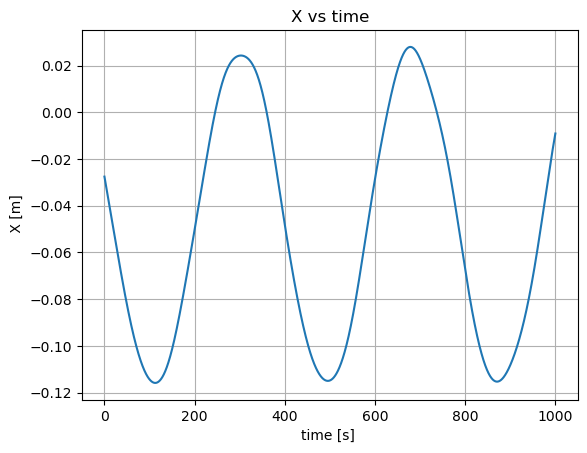

In [17]:
plt.figure()
plt.plot(time ,Rh[:,0])
plt.xlabel("time [s] ")
plt.ylabel(" X [m]")
plt.title("X vs time")
plt.grid()
plt.show()

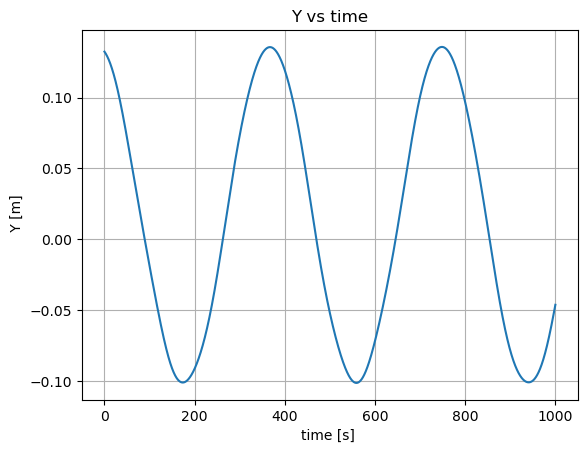

In [18]:
plt.figure()
plt.plot(time ,Rh[:,1])
plt.xlabel("time [s] ")
plt.ylabel(" Y [m]")
plt.title("Y vs time")
plt.grid()
plt.show()

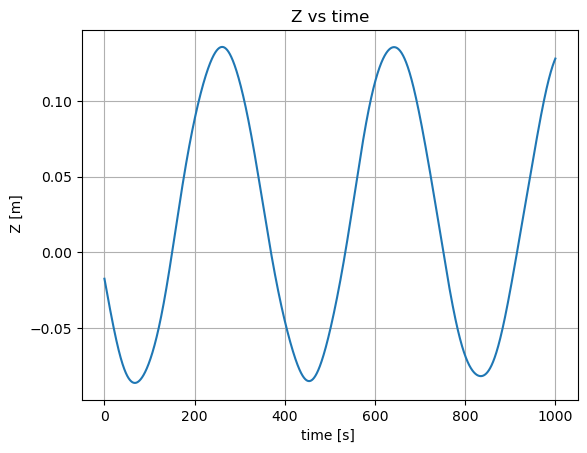

In [19]:
plt.figure()
plt.plot(time ,Rh[:,2])
plt.xlabel("time [s] ")
plt.ylabel(" Z [m]")
plt.title("Z vs time")
plt.grid()
plt.show()

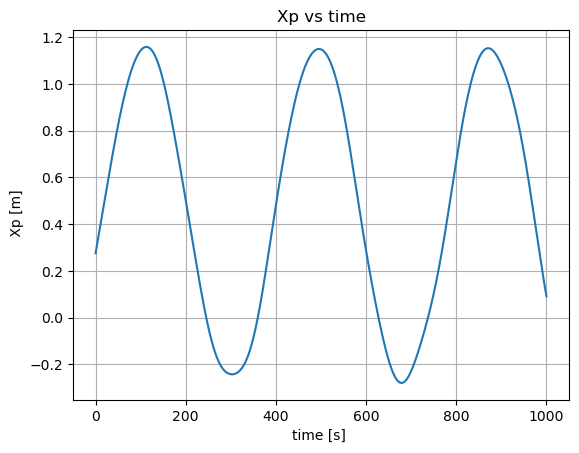

In [20]:
plt.figure()
plt.plot(time ,Rp[:,0])
plt.xlabel("time [s] ")
plt.ylabel(" Xp [m]")
plt.title("Xp vs time")
plt.grid()
plt.show()

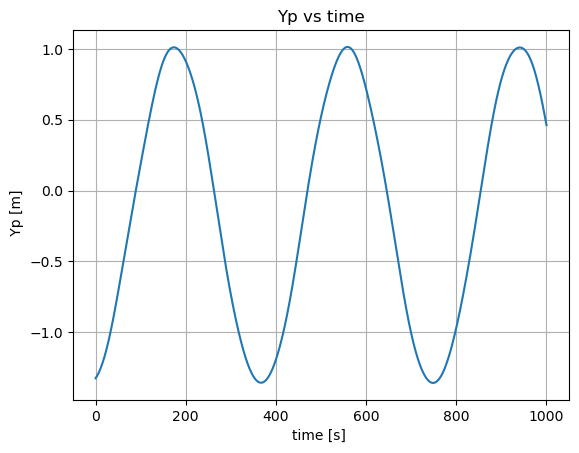

In [21]:
plt.figure()
plt.plot(time ,Rp[:,1])
plt.xlabel("time [s] ")
plt.ylabel(" Yp [m]")
plt.title("Yp vs time")
plt.grid()
plt.show()

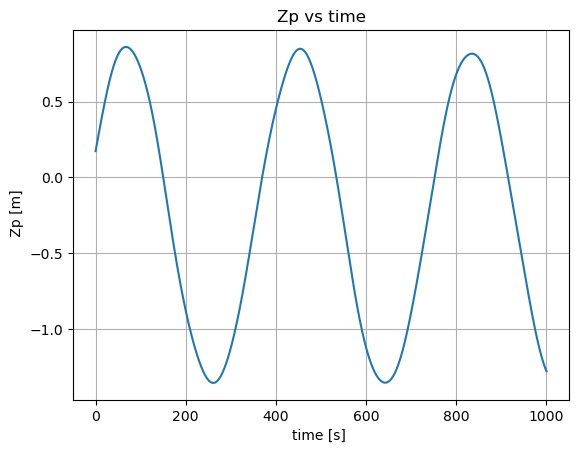

In [22]:
plt.figure()
plt.plot(time ,Rp[:,2])
plt.xlabel("time [s] ")
plt.ylabel(" Zp [m]")
plt.title("Zp vs time")
plt.grid()
plt.show()

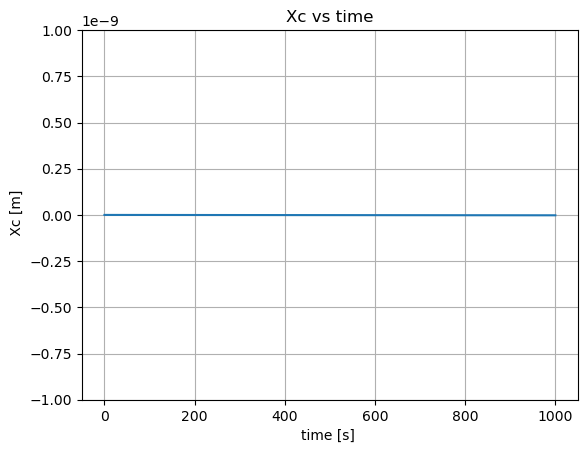

In [23]:
plt.figure()
plt.plot(time ,Rc[:,0])
plt.xlabel("time [s] ")
plt.ylabel(" Xc [m]")
plt.title("Xc vs time")
plt.grid()
plt.ylim(-1e-9, 1e-9)
plt.show()

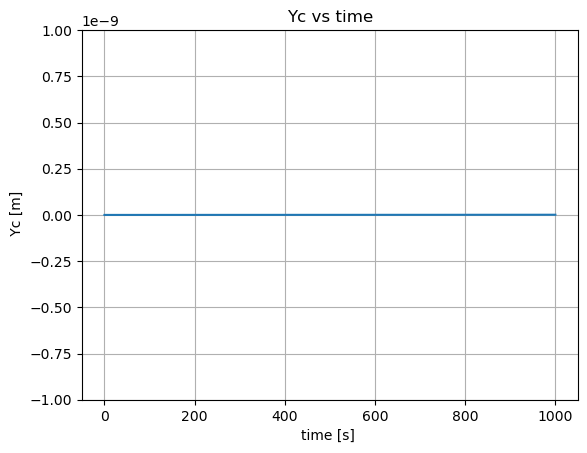

In [24]:
plt.figure()
plt.plot(time ,Rc[:,1])
plt.xlabel("time [s] ")
plt.ylabel(" Yc [m]")
plt.title("Yc vs time")
plt.grid()
plt.ylim(-1e-9, 1e-9)
plt.show()

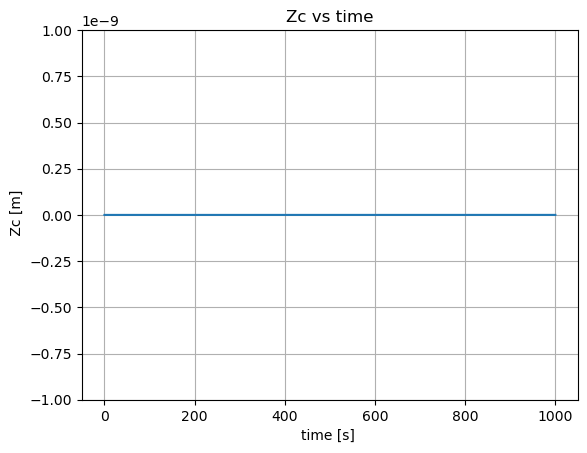

In [25]:
plt.figure()
plt.plot(time ,Rc[:,2])
plt.xlabel("time [s] ")
plt.ylabel(" Zc [m]")
plt.title("Zc vs time")
plt.grid()
plt.ylim(-1e-9, 1e-9)
plt.show()

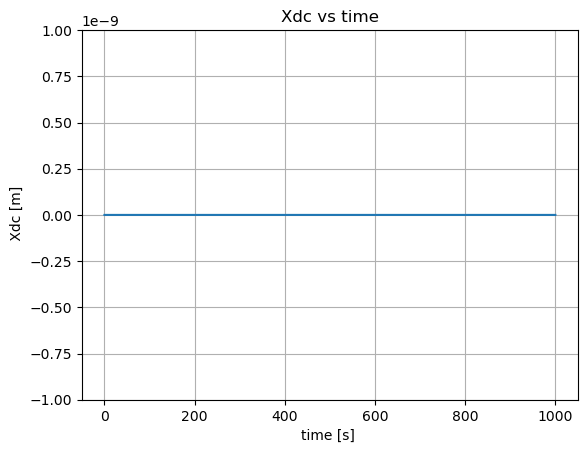

In [26]:
plt.figure()
plt.plot(time ,Rcd[:,0])
plt.xlabel("time [s] ")
plt.ylabel(" Xdc [m]")
plt.title("Xdc vs time")
plt.grid()
plt.ylim(-1e-9, 1e-9)
plt.show()

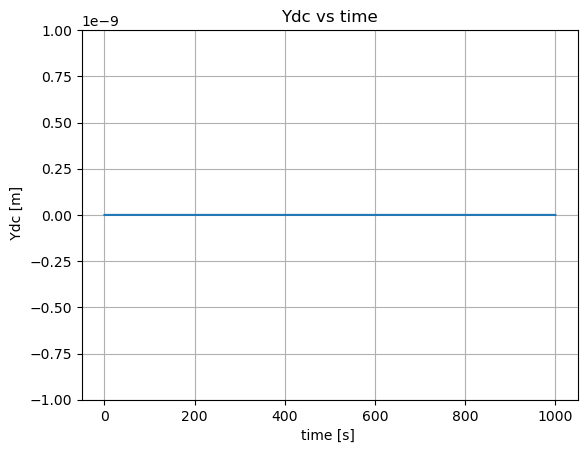

In [27]:
plt.figure()
plt.plot(time ,Rcd[:,1])
plt.xlabel("time [s] ")
plt.ylabel(" Ydc [m]")
plt.title("Ydc vs time")
plt.grid()
plt.ylim(-1e-9, 1e-9)
plt.show()

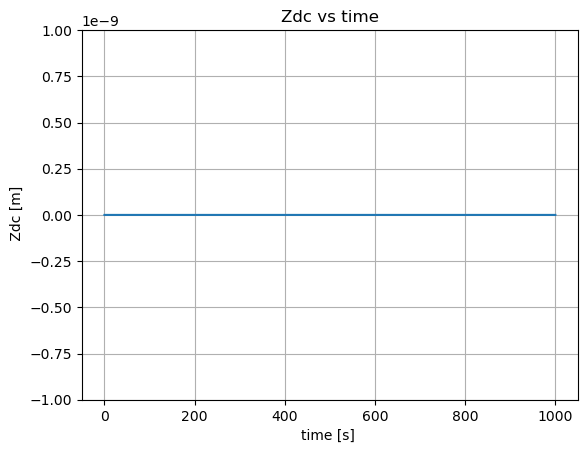

In [28]:
plt.figure()
plt.plot(time ,Rcd[:,2])
plt.xlabel("time [s] ")
plt.ylabel(" Zdc [m]")
plt.title("Zdc vs time")
plt.grid()
plt.ylim(-1e-9, 1e-9)
plt.show()

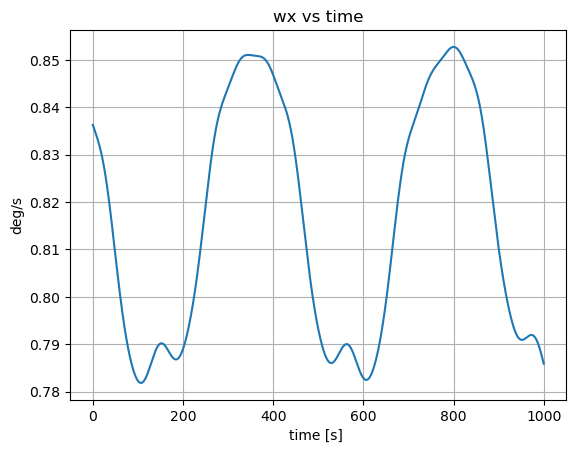

In [29]:
plt.figure()
plt.plot(time ,np.degrees(w[:,0]))
plt.xlabel("time [s] ")
plt.ylabel("deg/s")
plt.title("wx vs time")
plt.grid()
plt.show()

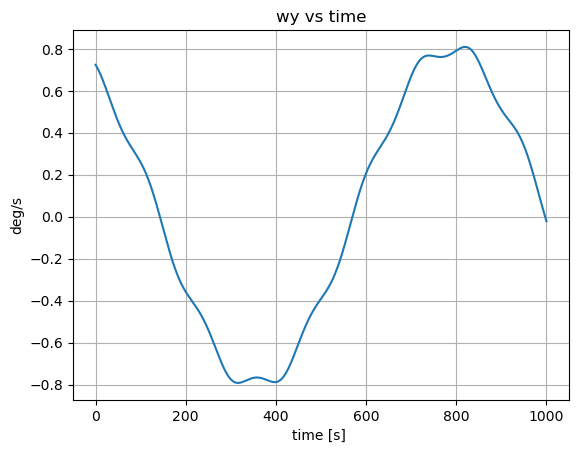

In [30]:
plt.figure()
plt.plot(time ,np.degrees(w[:,1]))
plt.xlabel("time [s] ")
plt.ylabel("deg/s")
plt.title("wy vs time")
plt.grid()
plt.show()

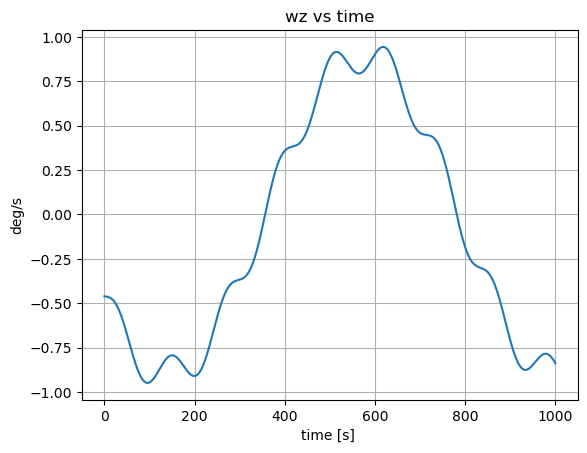

In [31]:
plt.figure()
plt.plot(time ,np.degrees(w[:,2]))
plt.xlabel("time [s] ")
plt.ylabel("deg/s")
plt.title("wz vs time")
plt.grid()
plt.show()

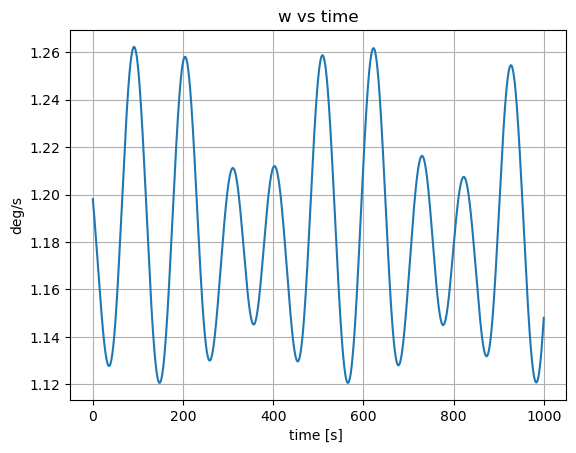

In [32]:
plt.figure()
plt.plot(time ,np.degrees(np.linalg.norm(w, axis=1)))
plt.xlabel("time [s] ")
plt.ylabel("deg/s")
plt.title("w vs time")
plt.grid()
plt.show()

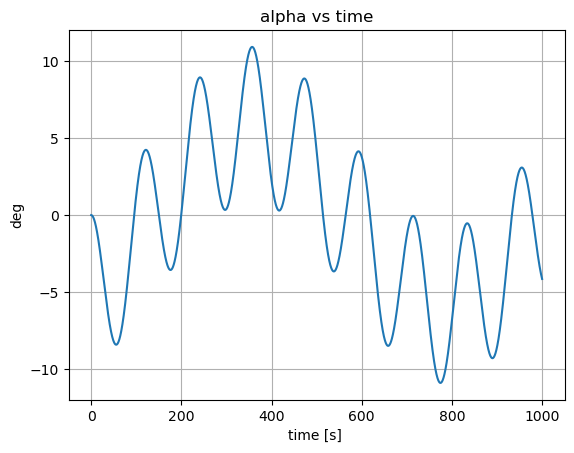

In [33]:
plt.figure()
plt.plot(time ,np.degrees(ang[:,3]))
plt.xlabel("time [s] ")
plt.ylabel("deg")
plt.title("alpha vs time")
plt.grid()
plt.show()

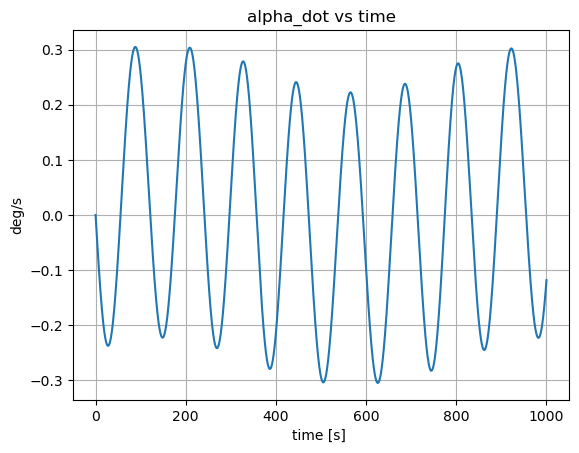

In [34]:
plt.figure()
plt.plot(time ,np.degrees(angd[:,3]))
plt.xlabel("time [s] ")
plt.ylabel("deg/s")
plt.title("alpha_dot vs time")
plt.grid()
plt.show()

In [35]:
# 3-D simulation

ds = 200

time_propogation = time[::ds]

r_cm_hub = Rh[::ds]
r_cm_panel = Rp[::ds]

hub_frame_i = CNH[::ds][:, 0, :]
hub_frame_j = CNH[::ds][:, 1, :]
hub_frame_k = CNH[::ds][:, 2, :]

panel_frame_i1 = CNP[::ds][:, 0, :]
panel_frame_j1 = CNP[::ds][:, 1, :]
panel_frame_k1 = CNP[::ds][:, 2, :]

hub_cm_X = Rh[::ds][:,0]
hub_cm_Y = Rh[::ds][:,1]
hub_cm_Z = Rh[::ds][:,2]

panel_alpha = np.degrees(ang[::ds][:,3])

combined_cm_Xc = Rc[::ds][:,0]
combined_cm_Yc = Rc[::ds][:,1]
combined_cm_Zc = Rc[::ds][:,2]

hub_omega_mag = np.degrees(np.linalg.norm(w, axis=1))[::ds]

# 3-2-1 yaw-pitch-roll in simple format

yaw = np.degrees(np.arctan2(CNH[:, 0, 1], CNH[:, 0, 0]))[::ds]

pitch = np.degrees(-np.arcsin(CNH[:, 0, 2]))[::ds]

roll = np.degrees(np.arctan2(CNH[:, 1, 2], CNH[:, 2, 2]))[::ds]


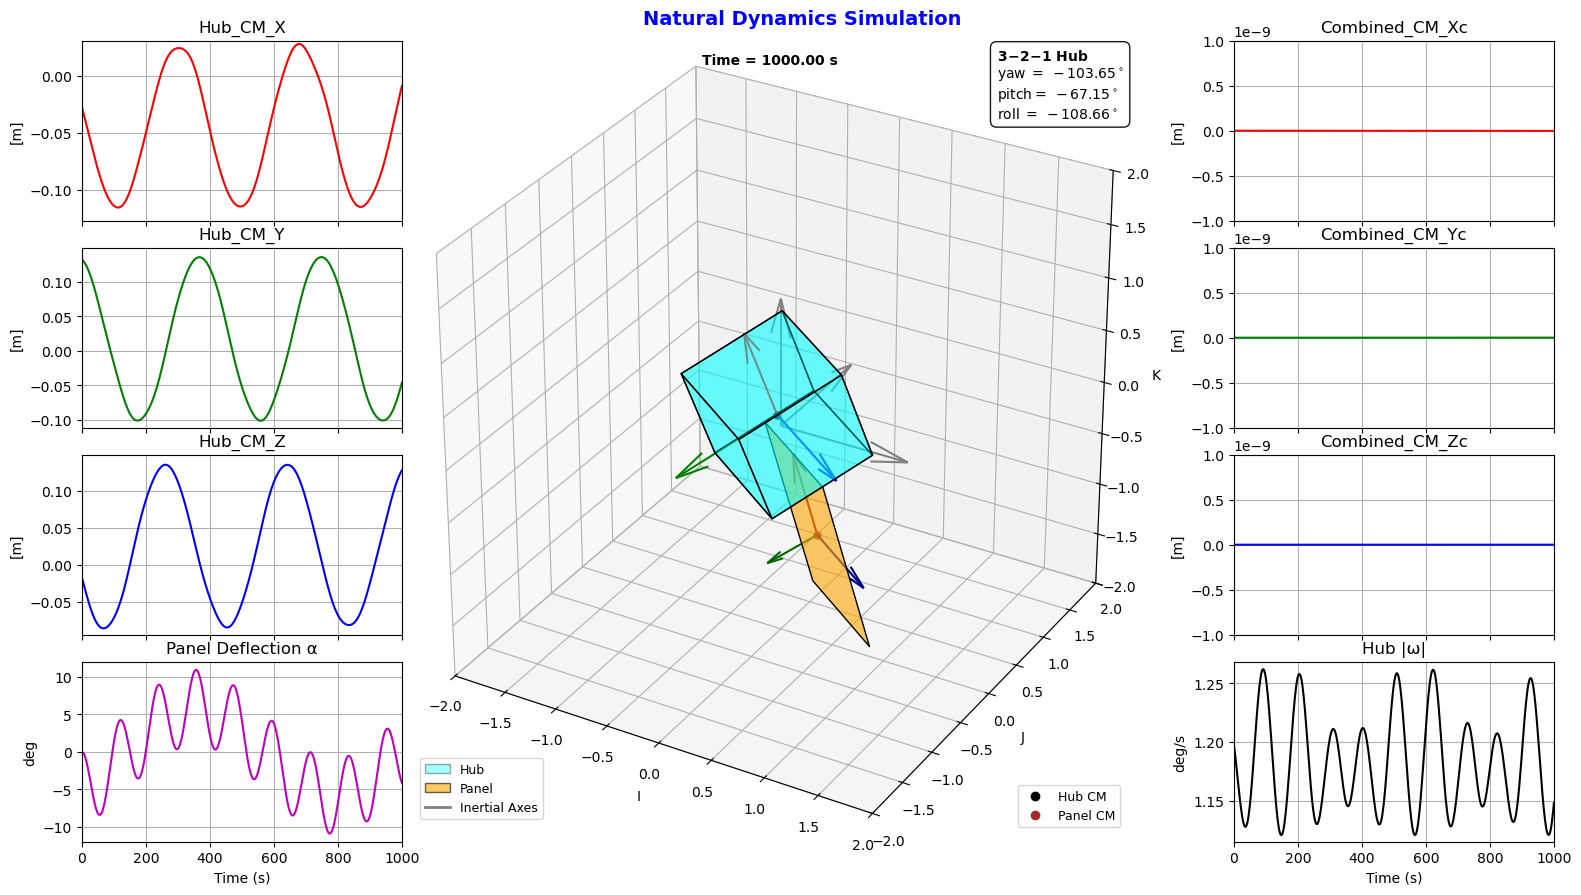

In [36]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# -------------------------------------------------
# INPUT DATA
# -------------------------------------------------
time = time_propogation

# Hub
i_vectors = hub_frame_i
j_vectors = hub_frame_j
k_vectors = hub_frame_k
r_cm_anim = r_cm_hub

# Panel
r_cm_panel_anim = r_cm_panel
i1_vectors = panel_frame_i1
j1_vectors = panel_frame_j1
k1_vectors = panel_frame_k1

# -------------------------------------------------
# HUB geometry (cube, CM at origin of hub frame)
# -------------------------------------------------
cube_vertices = np.array([
    [-0.5, -0.5, -0.5],
    [ 0.5, -0.5, -0.5],
    [ 0.5,  0.5, -0.5],
    [-0.5,  0.5, -0.5],
    [-0.5, -0.5,  0.5],
    [ 0.5, -0.5,  0.5],
    [ 0.5,  0.5,  0.5],
    [-0.5,  0.5,  0.5]
])

faces_idx = [
    [0,1,2,3],
    [4,5,6,7],
    [0,1,5,4],
    [2,3,7,6],
    [1,2,6,5],
    [4,7,3,0]
]

# -------------------------------------------------
# PANEL geometry (rectangle in panel frame)
# -------------------------------------------------
L = 2.0   # length (along i1)
W = 1.0   # width  (along k1)

panel_vertices = np.array([
    [-L/2, 0.0, -W/2],
    [ L/2, 0.0, -W/2],
    [ L/2, 0.0,  W/2],
    [-L/2, 0.0,  W/2]
])

panel_face = [[0, 1, 2, 3]]

# -------------------------------------------------
# FIGURE
# -------------------------------------------------
fig = plt.figure(figsize=(16, 9))

fig.text(
    0.5, 0.985,
    "Natural Dynamics Simulation",
    ha='center',
    va='top',
    fontsize=14,
    fontweight='bold',
    color='blue'
)


# 3D axis
ax3d = fig.add_axes([0.03, 0.06, 0.9, 0.9], projection='3d')

legend_left = [
    Patch(facecolor='cyan', edgecolor='k', alpha=0.35, label='Hub'),
    Patch(facecolor='orange', edgecolor='k', alpha=0.6, label='Panel'),
    Line2D([0], [0], color='0.5', lw=2, label='Inertial Axes'),
]

legend_right = [
    Line2D([0], [0], marker='o', color='k',
           linestyle='None', markersize=6, label='Hub CM'),
    Line2D([0], [0], marker='o', color='brown',
           linestyle='None', markersize=6, label='Panel CM'),
]


# -------------------- 2D axes --------------------

dy = 0.03   # vertical upward shift (figure fraction)

# Left side

axL1 = fig.add_axes([0.05, 0.72 + dy, 0.20, 0.20])
axL2 = fig.add_axes([0.05, 0.49 + dy, 0.20, 0.20])
axL3 = fig.add_axes([0.05, 0.26 + dy, 0.20, 0.20])
axL4 = fig.add_axes([0.05, 0.03 + dy, 0.20, 0.20])


# Right side
axR1 = fig.add_axes([0.77, 0.72 + dy, 0.20, 0.20])
axR2 = fig.add_axes([0.77, 0.49 + dy, 0.20, 0.20])
axR3 = fig.add_axes([0.77, 0.26 + dy, 0.20, 0.20])
axR4 = fig.add_axes([0.77, 0.03 + dy, 0.20, 0.20])

# -------------------------------------------------
# Initialize 2D lines
# -------------------------------------------------
line_L1, = axL1.plot([], [], 'r', lw=1.5)
line_L2, = axL2.plot([], [], 'g', lw=1.5)
line_L3, = axL3.plot([], [], 'b', lw=1.5)
line_L4, = axL4.plot([], [], 'm', lw=1.5)

line_R1, = axR1.plot([], [], 'r', lw=1.5)
line_R2, = axR2.plot([], [], 'g', lw=1.5)
line_R3, = axR3.plot([], [], 'b', lw=1.5)
line_R4, = axR4.plot([], [], 'k', lw=1.5)

# Set titles
axL1.set_title("Hub_CM_X")
axL2.set_title("Hub_CM_Y")
axL3.set_title("Hub_CM_Z")
axL4.set_title("Panel Deflection α")

axR1.set_title("Combined_CM_Xc")
axR2.set_title("Combined_CM_Yc")
axR3.set_title("Combined_CM_Zc")
axR4.set_title("Hub |ω|")

axL1.set_ylabel("[m]")
axL2.set_ylabel("[m]")
axL3.set_ylabel("[m]")
axL4.set_ylabel("deg")

axR1.set_ylabel("[m]")
axR2.set_ylabel("[m]")
axR3.set_ylabel("[m]")
axR4.set_ylabel("deg/s")


# Set x-limits and grid
for ax in [axL1, axL2, axL3, axL4, axR1, axR2, axR3, axR4]:
    ax.set_xlim(time[0], time[-1])
    ax.grid(True)

# -------------------------------------------------
# Set Y limits for 2D plots (fixed for animation)
# -------------------------------------------------

axL1.set_ylim(1.1*np.min(hub_cm_X), 1.1*np.max(hub_cm_X))
axL2.set_ylim(1.1*np.min(hub_cm_Y), 1.1*np.max(hub_cm_Y))
axL3.set_ylim(1.1*np.min(hub_cm_Z), 1.1*np.max(hub_cm_Z))
axL4.set_ylim(1.1*np.min(panel_alpha), 1.1*np.max(panel_alpha))

axR1.set_ylim(-1e-9, 1e-9)
axR2.set_ylim(-1e-9, 1e-9)
axR3.set_ylim(-1e-9, 1e-9)
axR4.set_ylim(0.995*np.min(hub_omega_mag), 1.005*np.max(hub_omega_mag))


# Only bottom plots get time label
axL4.set_xlabel("Time (s)")
axR4.set_xlabel("Time (s)")

# Remove x tick labels from upper plots
for ax in [axL1, axL2, axL3, axR1, axR2, axR3]:
    ax.set_xticklabels([])

# -------------------------------------------------
# Animation update function
# -------------------------------------------------
def update_frame(frame):
    ax3d.cla()

    # ---- LEFT legend (Hub, Panel, Inertial Axes) ----
    leg_left = ax3d.legend(
    handles=legend_left,
    loc='lower left',
    bbox_to_anchor=(0.06, 0.02),
    fontsize=9,
    frameon=True
    )

    # ---- RIGHT legend (CMs) ----
    leg_right = ax3d.legend(
    handles=legend_right,
    loc='lower right',
    bbox_to_anchor=(0.94, 0.01),
    fontsize=9,
    frameon=True
    )

    # keep both legends
    ax3d.add_artist(leg_left)

  

    # 3D plot
    ax3d.set_xlim([-2, 2 ])
    ax3d.set_ylim([-2, 2])
    ax3d.set_zlim([-2, 2])
    ax3d.set_box_aspect([1,1,1])

    ax3d.set_xlabel("I")
    ax3d.set_ylabel("J")
    ax3d.set_zlabel("K")

    ax3d.text2D(
        0.5, 0.96,
        f"Time = {time[frame]:.2f} s",
        transform=ax3d.transAxes,
        ha='center',
        fontweight='bold',
        fontsize=10
    )

  

    # ---------------- Euler angle info box ----------------
    euler_text = (
    r"$\bf{3\!-\!2\!-\!1\ Hub}$" "\n"
    rf"$\mathrm{{yaw}} \;=\; {yaw[frame]:6.2f}^\circ$" "\n"
    rf"$\mathrm{{pitch}}=\; {pitch[frame]:6.2f}^\circ$" "\n"
    rf"$\mathrm{{roll}} \;=\; {roll[frame]:6.2f}^\circ$"
    )

    ax3d.text2D(
    0.78, 0.98,                 # right of Time
    euler_text,
    transform=ax3d.transAxes,
    ha='left',
    va='top',
    fontsize=10,
    bbox=dict(
        boxstyle="round,pad=0.45",
        facecolor="white",
        edgecolor="black",
        alpha=0.9
    )
    )



    # Inertial axes
    ax3d.quiver(0,0,0, 1,0,0, color='0.5', length=1.2)
    ax3d.quiver(0,0,0, 0,1,0, color='0.5', length=1.2)
    ax3d.quiver(0,0,0, 0,0,1, color='0.5', length=1.2)

    # Hub
    rCM_hub = r_cm_anim[frame]
    R_hub = np.vstack([i_vectors[frame], j_vectors[frame], k_vectors[frame]]).T
    hub_vertices_I = cube_vertices @ R_hub.T + rCM_hub
    hub_faces = [[hub_vertices_I[j] for j in f] for f in faces_idx]

    hub = Poly3DCollection(hub_faces, facecolors='cyan', edgecolors='k', alpha=0.35)
    ax3d.add_collection3d(hub)

    ax3d.quiver(*rCM_hub, *i_vectors[frame], color='r', length=1.0)
    ax3d.quiver(*rCM_hub, *j_vectors[frame], color='g', length=1.0)
    ax3d.quiver(*rCM_hub, *k_vectors[frame], color='b', length=1.0)
    ax3d.scatter(*rCM_hub, color='k', s=25)

    # Panel
    rCM_panel = r_cm_panel_anim[frame]
    R_panel = np.vstack([i1_vectors[frame], j1_vectors[frame], k1_vectors[frame]]).T
    panel_vertices_I = panel_vertices @ R_panel.T + rCM_panel
    panel_faces_I = [[panel_vertices_I[j] for j in f] for f in panel_face]

    panel = Poly3DCollection(panel_faces_I, facecolors='orange', edgecolors='k', alpha=0.6)
    ax3d.add_collection3d(panel)

    ax3d.quiver(*rCM_panel, *i1_vectors[frame], color='darkred', length=1.0)
    ax3d.quiver(*rCM_panel, *j1_vectors[frame], color='darkgreen', length=0.5)
    ax3d.quiver(*rCM_panel, *k1_vectors[frame], color='darkblue', length=0.8)
    ax3d.scatter(*rCM_panel, color='brown', s=25)

    # ----------------- Update 2D plots -----------------
    t = time[:frame+1]

    # Left
    line_L1.set_data(t, hub_cm_X[:frame+1])
    line_L2.set_data(t, hub_cm_Y[:frame+1])
    line_L3.set_data(t, hub_cm_Z[:frame+1])
    line_L4.set_data(t, panel_alpha[:frame+1])

    # Right
    line_R1.set_data(t, combined_cm_Xc[:frame+1])
    line_R2.set_data(t, combined_cm_Yc[:frame+1])
    line_R3.set_data(t, combined_cm_Zc[:frame+1])
    line_R4.set_data(t, hub_omega_mag[:frame+1])

    return []

    # Figure-level time labels
    
    fig.text(0.16, 0.005, "Time (s)", ha='center', fontsize=11)
    fig.text(0.87, 0.005, "Time (s)", ha='center', fontsize=11)

 
# -------------------------------------------------
# Animation
# -------------------------------------------------
fps = len(time) / 10.0
interval_ms = 1000 / fps

ani = FuncAnimation(
    fig,
    update_frame,
    frames=len(time),
    interval=interval_ms,
    blit=False
)

writer = FFMpegWriter(fps=fps, bitrate=6000)
ani.save("hub_panel_free_motion_with_2Dplots.mp4", writer=writer, dpi=100)

plt.show()
